#  Определение количества заказов для сервиса такси

## Описание проекта
***
Руководство компании, предоставляющие услуги такси, желает оптимизировать нагрузку на водителей в час пик. Для этого пранируется привлекать больше водителей в период пиковой нагрузки.
***
## Цель
Необходимо построить модель для предсказания количества заказов такси на следующий час.
***
Заказчику важно:
- качество предсказания;
- время обучения модели;
- время предсказания модели;
- значение метрики RMSE должно быть меньше 48
***

**Загрузка библиотек**

In [1]:
!pip install --upgrade scikit-learn
!pip install --upgrade phik

import pandas as pd
import numpy as np
import seaborn as sns
import phik
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

**Установка глобальных переменных**

In [2]:
RANDOM_STATE = 42
lags_number = 24*7

## Подготовка

**Загрузка данных**

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

**Проверка соответствия данных описанию**

In [4]:
df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01,9


Данные соответствуют описанию

**Проверка наличия пропусков**

In [5]:
df.isna().sum()

num_orders    0
dtype: int64

Пропуски отсутствуют

**Ресэмплирование**

In [6]:
df = df.resample('1H').sum()

***
**Вывод:**
- Данные соответствуют описанию;
- Наименования столбцов корректны;
- Пропуски отсутствуют;
- Выполнено ресэмплирование по одному часу.
***

## Анализ

**Проверка на хронологичность**

In [7]:
df.index.is_monotonic

True

Данные приведены в хронологическом порядке

**Общий осмотр данных**

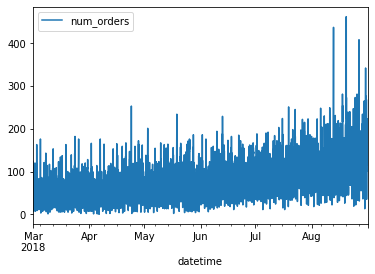

In [8]:
df.plot();

**Анализ параметров временного ряда**

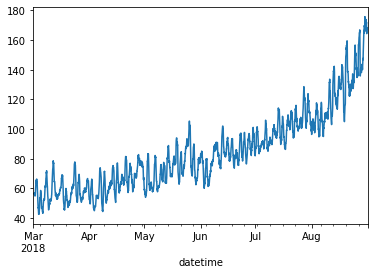

In [9]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot();

График нестационарен так как его среднее количество заказов растёт

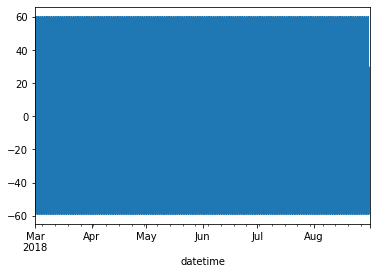

In [10]:
decomposed.seasonal.plot();

График трудно анализировать. Необходимо взять меньший промежуток времени. Возьмём первую неделю марта.

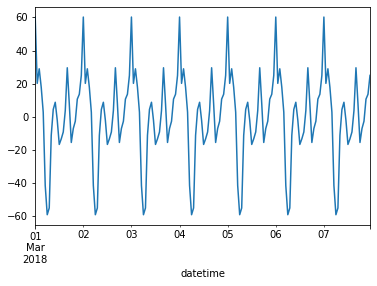

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot();

По графику видно, что период графика составляет один день

Построим также график временного ряда за 4 недели, ресэмплированного по 1 дню.

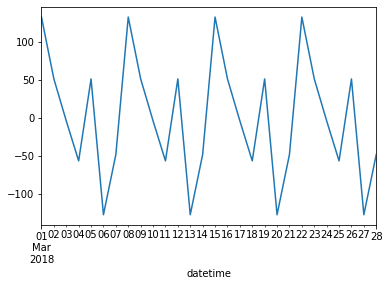

In [12]:
seasonal_decompose(df.resample('1D').sum()[:'2018-03-28']).seasonal.plot();

По графику видно, что наибольшее количество заказов приходится на четверг и понедельник, а наименьшее количество заказов - на вторник и воскресенье.

<AxesSubplot:xlabel='datetime'>

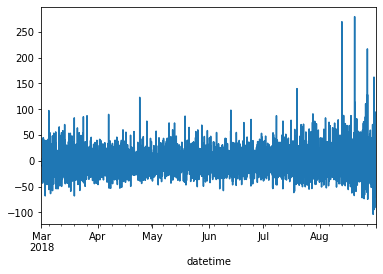

In [13]:
decomposed.resid.plot()

На графике есть несколько высоких значений.

**Проверка на стационарность временного ряда:**

In [14]:
fuller = adfuller(df, autolag='AIC', store=False, regresults=False)
if fuller[0] > fuller[4]['5%']:
    print('Временной ряд не стационарен')
else:
    print('Временной ряд стационарен')

Временной ряд стационарен


***
**Вывод:**
- Временной ряд содержит данные за полугодовой период: с марта по август 2018 года;
- Тренд временного ряда возрастает;
- Период графика составляет один день;
- Наибольшее количество заказов приходится на четверг и понедельник, а наименьшее количество заказов - на вторник и воскресенье.
- На временном ряде есть несколько высоких значений.
***

## Обучение

**Добавление дополнительных признаков**

In [15]:
def add_features(df, max_lag):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(max_lag):
        df[f'lag_{lag + 1}'] = df['num_orders'].shift(lag + 1)

In [16]:
add_features(df, lags_number)

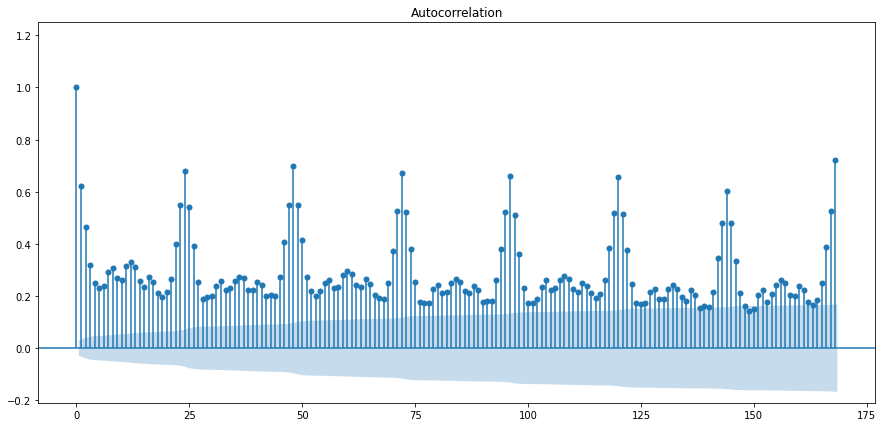

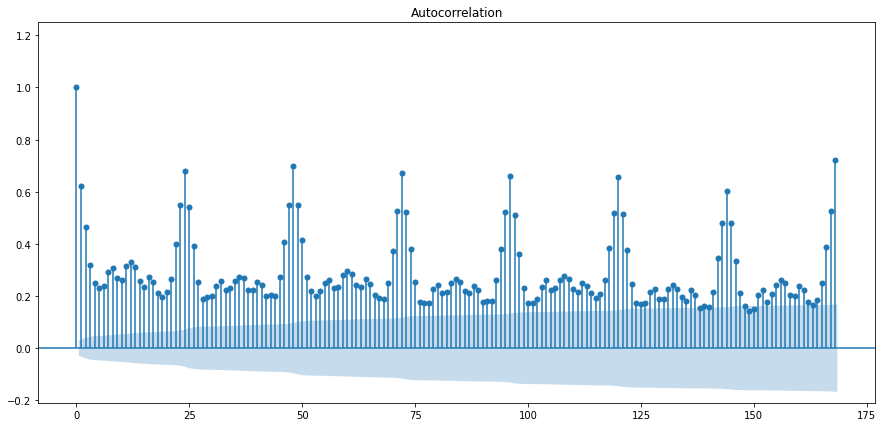

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plot_acf(df['num_orders'], ax=ax, lags=24*7, auto_ylims=True)

**Выделение целевого признака**

In [18]:
df = df.dropna()
X = df.drop('num_orders', axis=1)
y = df['num_orders']

**Разбивка данных на выборки**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

**Подготовка пайплайна**

In [20]:
pipe_final = Pipeline([
    ('prep', ColumnTransformer([('num', StandardScaler(), X_train.columns.tolist())], remainder='passthrough')),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [21]:
params = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_leaf': range(1, 10),
        'prep__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'prep__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [22]:
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(
    pipe_final,
    param_grid=params,
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [23]:
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['dayofweek',
                                                                          'hour',
                                                                          'lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'lag_4',
                                                                          'lag_5',
                                                                          'lag_6',
                                                                          'lag_7',
                                                                          'lag_8',
                                                                          'lag_9',
                                                                          'lag_10',
                                                                          'lag_11',
                                                                          'lag_12',
                                                                          'lag_13',
                                                                          'lag_14',
                                                                          'lag_15',
                                                                          'lag_...
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(2, 11),
                          'models__min_samples_leaf': range(1, 10),
                          'prep__num': [StandardScaler(), MinMaxScaler(),
                                        RobustScaler(), 'passthrough']},
                         {'models': [LinearRegression()],
                          'prep__num': [StandardScaler(), MinMaxScaler(),
                                        RobustScaler(), 'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [24]:
print(f'Лучшая модель -', grid.best_estimator_['models'], f'\nЛучшая метрика {round(- grid.best_score_, 2)}')

Лучшая модель - LinearRegression() 
Лучшая метрика 22.69


***
**Вывод:**
- Добавлены дополнительные признаки;
- Построен пайплайн;
- В пайплайне использовано несколько моделей с разными гиперпараметрами;
- Выбор моделей продиктован информативнотью и интерпритируемостью признаков
- Лучшая модель - линейная регрессия;
- Метрика обучения лучшей модели на обучающей выборке - 22.69
***

## Тестирование

**Проверка найденной лучшей модели с лучшими гиперпараметрами на тестовой выборке:**

In [25]:
round(root_mean_squared_error(y_test, grid.best_estimator_.predict(X_test)), 2)

34.26

Метрика соответствует требованиям заказчика

**Построим график важности факторов**

In [26]:
try:
    result = pd.DataFrame(index=df.columns[1:], data=grid.best_estimator_['models'].coef_)
except:
    result = pd.DataFrame(index=df.columns[1:], data=grid.best_estimator_['models'].feature_importances_)

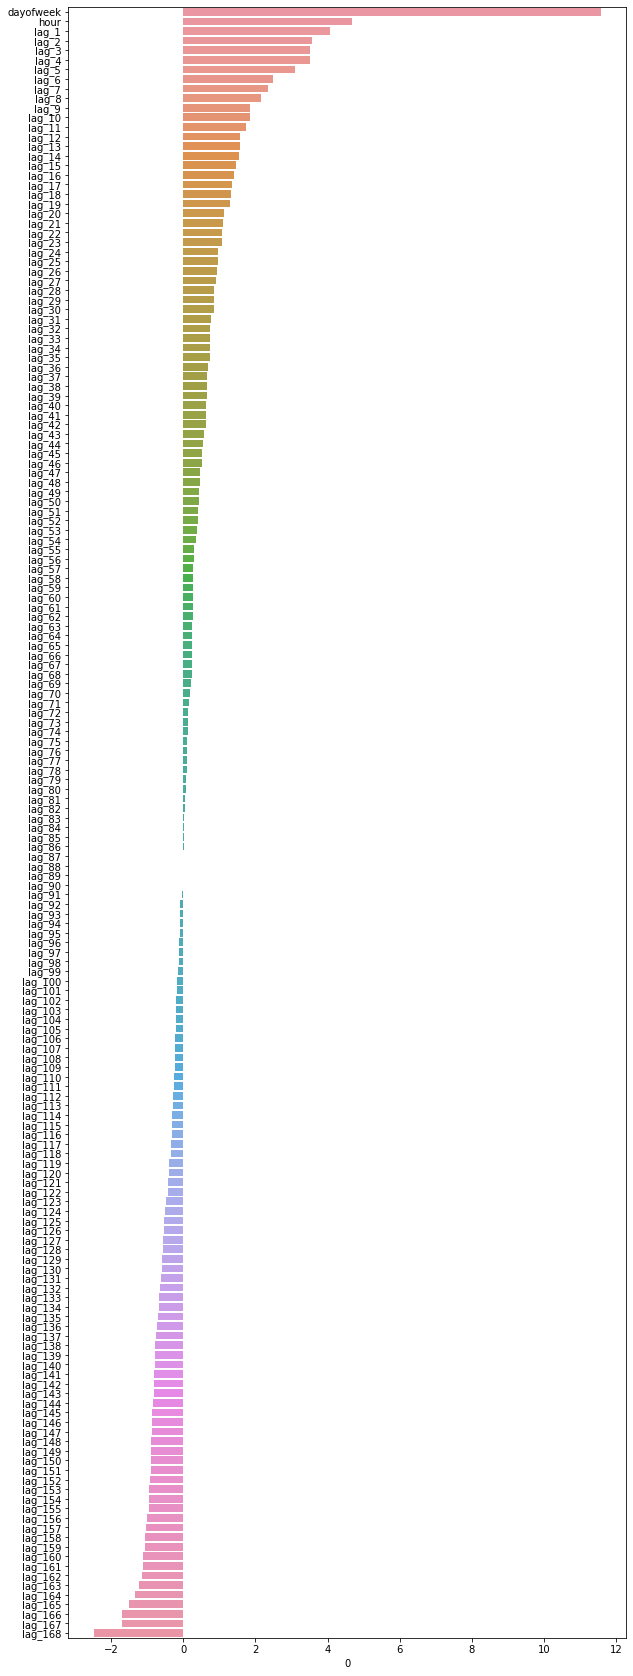

In [27]:
plt.figure(figsize=(10, 30))
sns.barplot(x=result[0].sort_values(ascending=False), y=result.index);

***
**Вывод:**
- Метрика лучшей модели на тестовой выборке - 34.26;
- Построен график важности факторов.

***
# Вывод
- **Подготовка данных:**
    - Данные соответствуют описанию;
    - Наименования столбцов корректны;
    - Пропуски отсутствуют;
    - Выполнено ресэмплирование по одному часу.


- **Анализ:**
    - Временной ряд содержит данные за полугодовой период: с марта по август 2018 года;
    - Тренд временного ряда возрастает;
    - Период графика составляет один день;
    - На временном ряде есть несколько высоких значений.


- **Обучение:**
    - Добавлены дополнительные признаки;
    - Построен пайплайн;
    - В пайплайне использовано несколько моделей с разными гиперпараметрами;
    - Выбор моделей продиктован информативнотью и интерпритируемостью признаков
    - Лучшая модель - линейная регрессия;
    - Метрика обучения лучшей модели на обучающей выборке - 22.69


- **Тестирование:**
    - Метрика лучшей модели на тестовой выборке - 34.26;
    - Построен график важности факторов.
***